# Reading french texts

In [1]:
# imports
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

In [2]:
# fetching data
PATH = "./data/ArticleCompany_2020-11-17/"
coprus = "corpus_check_long_SIREN_UPDATED2"
names = "siren_name_map_clean"

In [3]:
#df_name = pd.read_json(PATH + names +".json")
with open(PATH + names +".json") as json_file: 
    dict_names = json.load(json_file) 

with open(PATH + coprus +".json") as json_file: 
    corpus_list = json.load(json_file) 

In [4]:
print ("There are", len(corpus_list), "articles in the corpus")
print ("There are", len(dict_names), "companies in the list")

There are 57540 articles in the corpus
There are 30178 companies in the list


## Compter Nombre d'Entreprises sans Articles

In [5]:
dict_count = dict()
#for company in dict_names.keys(): dict_count[company] = 0
for document in corpus_list:
    #print (document["siren"])
    sir_list = document["siren"][1:-1].split(", ")
    #print (sir_list)
    for siren in sir_list:
        #print (siren)
        if siren in dict_count.keys():
            dict_count[siren] +=1
        else:
            dict_count[siren] = 1
print ("There are",len(dict_count.keys()),"companies with labels out of the", len(dict_names.keys()), "companies")
print ("there are",len(dict_names.keys())-len(dict_count.keys()),"companies with no articles")
print (round(len(dict_count)/(len(dict_names))*100,2),"% of the companies have articles")

There are 28690 companies with labels out of the 30178 companies
there are 1488 companies with no articles
95.07 % of the companies have articles


## Quels sont les entreprises sans articles?

In [6]:
dict_no_acticle_companies = dict()
for company in dict_names.keys():
    if company not in dict_count.keys():
        dict_no_acticle_companies[company] = dict_names[company] 

# Etudes du nombre d'articles associer a chaque entreprise 

In [7]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

DescribeResult(nobs=28690, minmax=(1, 175), mean=2.502195887068665, variance=28.018556298899046, skewness=11.346985559301654, kurtosis=211.55000716780165)
There are 63.58 % articles with one associated article
There are 90.42 % articles with less than 5 associated article


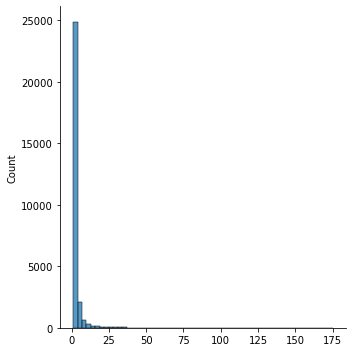

In [8]:
# On prendre seulement les entreprises avec au moins un articles associer
#sns.set(rc={'figure.figsize':(40,5)})
values = list(dict_count.values())
sns.displot(values, binwidth=3) #bins=20

number = 5
print(stats.describe(values))
print ("There are",round(values.count(1)/len(values)*100,2), "% articles with one associated article")
under_n = [1 for i in values if i < number]
print ("There are",round(len(under_n)/len(values)*100,2), "% articles with less than",number,"associated article")

# Tokenize and remove stop words of Corpus

In [9]:
#imports
import nltk
import re
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stop_words = stopwords.words('french')

In [10]:
print ("Number of stop words",len(stop_words ))
print ("Ex:",stop_words[:5])

Number of stop words 157
Ex: ['au', 'aux', 'avec', 'ce', 'ces']


In [11]:
corpus_cleaned = list(corpus_list)
for document in tqdm(corpus_cleaned):
    plain_text = document["corpus"]
    plain_text = plain_text.lower()
    plain_text= re.sub(r'\s+', ' ', plain_text)
    #plain_text = re.sub("[^a-z0-9]", ' ', plain_text)
    plain_text = re.sub("[^a-z]", ' ', plain_text)
    plain_text = re.sub(r'\s+', ' ', plain_text)
    #remove one letter words?
    #remove numbers?
    pt_words = word_tokenize(plain_text)
    cleaned_words =list()
    for word in pt_words:
        if len(word)>1:
            if word not in stop_words:
                cleaned_words.append(word)
    document["corpus"] = cleaned_words
# 100%|██████████| 57540/57540 [03:30<00:00, 273.74it/s]

100%|██████████| 57540/57540 [04:03<00:00, 235.94it/s]


# Tf.Idf pour une entreprise

In [12]:
# imports
from sklearn.feature_extraction.text import TfidfVectorizer 

In [13]:
corpus_cleaned[0]
print(list(dict_names.keys())[0:5])
print (dict_names['399258755'])
name_search = "APPLE FRANCE"
for siren, name in dict_names.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if name_search in name:
        print(siren, name)
print("APPLE FRANCE a",dict_count["322120916"],"articles dans le corpus")

['419838529', '813883964', '572060333', '542104245', '399258755']
SPIE OPERATIONS
322120916 APPLE FRANCE
APPLE FRANCE a 7 articles dans le corpus


In [14]:
number = 5
siren_filtered =[key for key in dict_count if dict_count[key] > number]
len(siren_filtered)

2084

In [15]:
# Tf.Idf on Companies that have Associated Articles 
relevant_words_tfidf = {}
#list_siren = list(dict_count.keys())
list_siren = siren_filtered[:100]
def identity_tokenizer(text):
    return text
for siren in tqdm(list_siren):
    #siren = "322120916" #APPLE FRANCE
    plain_text_list = list()
    company_article = list()
    tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, ngram_range = (1,1), lowercase=False)

    for document in corpus_cleaned:
        if siren in document["siren"]:
            company_article = company_article+document["corpus"]  # add article to company BIG article
        else:
            plain_text_list.append(document["corpus"]) # otherwise add to corpus

    plain_text_list.insert(0,company_article) # add company article to begging of corpus
    tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(plain_text_list)

    #Get the tf-idf scores for the words in the company article complication.
    first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0] # discard tf.idf scores for the other texts

    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
    df = df.sort_values(by=["tfidf"],ascending=False).head(40) # Take top 40 words

    relevant_words_tfidf[siren] = list(zip(list(df.index),list(df["tfidf"])))
    #print (relevant_words_tfidf[company])

#100%|██████████| 100/100 [22:35<00:00, 13.55s/it]

100%|██████████| 100/100 [22:35<00:00, 13.55s/it]


In [ ]:
relevant_words_tfidf

In [17]:
# save dictionary
PATH = "./relevant_words/francais/"
file = "relevant_words_tfidf_5articles_small"
a_file = open(PATH + file + ".json", "w")
json.dump(relevant_words_tfidf, a_file)
a_file.close()

In [18]:
# load dictionary 
PATH = "./relevant_words/francais/"
file = "relevant_words_tfidf_5articles_small"
a_file = open(PATH + file + ".json", "r")
relevant_words_tfidf = json.load(a_file)
#relevant_words_tfidf = dict(relevant_words_tfidf)

In [21]:
#relevant_words_tfidf.keys()
#relevant_words_tfidf['419838529']